# Exercise 6 : Support Vector Machines
---

In [1]:
%  Instructions
%  ------------
% 
%  This file contains code that helps you get started on the
%  exercise. You will need to complete the following functions:
%
%     gaussianKernel.m
%     dataset3Params.m
%     processEmail.m
%     emailFeatures.m
%
%  For this exercise, you will not need to change any code in this file,
%  or any other files other than those mentioned above.

In [2]:
%% Initialization
clear ; close all; clc

In [3]:
%% =============== Part 1: Loading and Visualizing Data ================
%  We start the exercise by first loading and visualizing the dataset. 
%  The following code will load the dataset into your environment and plot
%  the data.

In [4]:
fprintf('Loading and Visualizing Data ...\n')

Loading and Visualizing Data ...


In [5]:
% Load from ex6data1: 
% You will have X, y in your environment
load('ex6data1.mat');

In [54]:
function plotData(X, y)
%PLOTDATA Plots the data points X and y into a new figure 
%   PLOTDATA(x,y) plots the data points with + for the positive examples
%   and o for the negative examples. X is assumed to be a Mx2 matrix.
%
% Note: This was slightly modified such that it expects y = 1 or y = 0
% Find Indices of Positive and Negative Examples
pos = find(y == 1); neg = find(y == 0);
% Plot Examples
plot(X(pos, 1), X(pos, 2), 'k+','LineWidth', 1, 'MarkerSize', 7)
hold on;
plot(X(neg, 1), X(neg, 2), 'ko', 'MarkerFaceColor', 'y', 'MarkerSize', 7)
hold off;
end

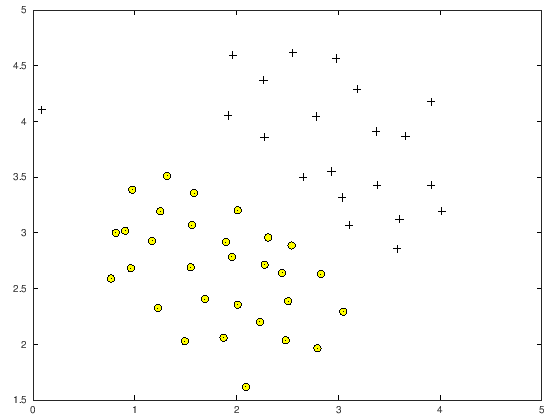

In [7]:
% Plot training data
plotData(X, y);

In [8]:
%% ==================== Part 2: Training Linear SVM ====================
%  The following code will train a linear SVM on the dataset and plot the
%  decision boundary learned.

In [194]:
% Load from ex6data1: 
% You will have X, y in your environment
load('ex6data1.mat');

In [195]:
fprintf('\nTraining Linear SVM ...\n')


Training Linear SVM ...


In [8]:
function visualizeBoundaryLinear(X, y, model)
%VISUALIZEBOUNDARYLINEAR plots a linear decision boundary learned by the
%SVM
%   VISUALIZEBOUNDARYLINEAR(X, y, model) plots a linear decision boundary 
%   learned by the SVM and overlays the data on it

w = model.w;
b = model.b;
xp = linspace(min(X(:,1)), max(X(:,1)), 100);
yp = - (w(1)*xp + b)/w(2);
plotData(X, y);
hold on;
plot(xp, yp, '-b'); 
hold off

end

In [9]:
function sim = linearKernel(x1, x2)
%LINEARKERNEL returns a linear kernel between x1 and x2
%   sim = linearKernel(x1, x2) returns a linear kernel between x1 and x2
%   and returns the value in sim

% Ensure that x1 and x2 are column vectors
x1 = x1(:); x2 = x2(:);

% Compute the kernel
sim = x1' * x2;  % dot product

end

In [10]:
function [model] = svmTrain(X, Y, C, kernelFunction, ...
                            tol, max_passes)
%SVMTRAIN Trains an SVM classifier using a simplified version of the SMO 
%algorithm. 
%   [model] = SVMTRAIN(X, Y, C, kernelFunction, tol, max_passes) trains an
%   SVM classifier and returns trained model. X is the matrix of training 
%   examples.  Each row is a training example, and the jth column holds the 
%   jth feature.  Y is a column matrix containing 1 for positive examples 
%   and 0 for negative examples.  C is the standard SVM regularization 
%   parameter.  tol is a tolerance value used for determining equality of 
%   floating point numbers. max_passes controls the number of iterations
%   over the dataset (without changes to alpha) before the algorithm quits.
%
% Note: This is a simplified version of the SMO algorithm for training
%       SVMs. In practice, if you want to train an SVM classifier, we
%       recommend using an optimized package such as:  
%
%           LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
%           SVMLight (http://svmlight.joachims.org/)
%
%

if ~exist('tol', 'var') || isempty(tol)
    tol = 1e-3;
end

if ~exist('max_passes', 'var') || isempty(max_passes)
    max_passes = 5;
end

% Data parameters
m = size(X, 1);
n = size(X, 2);

% Map 0 to -1
Y(Y==0) = -1;

% Variables
alphas = zeros(m, 1);
b = 0;
E = zeros(m, 1);
passes = 0;
eta = 0;
L = 0;
H = 0;

% Pre-compute the Kernel Matrix since our dataset is small
% (in practice, optimized SVM packages that handle large datasets
%  gracefully will _not_ do this)
% 
% We have implemented optimized vectorized version of the Kernels here so
% that the svm training will run faster.
if strcmp(func2str(kernelFunction), 'linearKernel')
    % Vectorized computation for the Linear Kernel
    % This is equivalent to computing the kernel on every pair of examples
    K = X*X';
elseif strfind(func2str(kernelFunction), 'gaussianKernel')
    % Vectorized RBF Kernel
    % This is equivalent to computing the kernel on every pair of examples
    X2 = sum(X.^2, 2);
    K = bsxfun(@plus, X2, bsxfun(@plus, X2', - 2 * (X * X')));
    K = kernelFunction(1, 0) .^ K;
else
    % Pre-compute the Kernel Matrix
    % The following can be slow due to the lack of vectorization
    K = zeros(m);
    for i = 1:m
        for j = i:m
             K(i,j) = kernelFunction(X(i,:)', X(j,:)');
             K(j,i) = K(i,j); %the matrix is symmetric
        end
    end
end

% Train
fprintf('\nTraining ...');
dots = 12;
while passes < max_passes,

    num_changed_alphas = 0;
    for i = 1:m,
        
        % Calculate Ei = f(x(i)) - y(i) using (2). 
        % E(i) = b + sum (X(i, :) * (repmat(alphas.*Y,1,n).*X)') - Y(i);
        E(i) = b + sum (alphas.*Y.*K(:,i)) - Y(i);
        %size(alphas.*Y.*K(:,i))
        %size(sum (alphas.*Y.*K(:,i)))
        %size(alphas)
        %size(Y)
        %size(K(:,i))
        if ((Y(i)*E(i) < -tol && alphas(i) < C) || (Y(i)*E(i) > tol && alphas(i) > 0)),

            % In practice, there are many heuristics one can use to select
            % the i and j. In this simplified code, we select them randomly.
            j = ceil(m * rand());
            while j == i,  % Make sure i \neq j
                j = ceil(m * rand());
            end

            % Calculate Ej = f(x(j)) - y(j) using (2).
            E(j) = b + sum (alphas.*Y.*K(:,j)) - Y(j);

            % Save old alphas
            alpha_i_old = alphas(i);
            alpha_j_old = alphas(j);

            % Compute L and H by (10) or (11). 
            if (Y(i) == Y(j)),
                L = max(0, alphas(j) + alphas(i) - C);
                H = min(C, alphas(j) + alphas(i));
            else
                L = max(0, alphas(j) - alphas(i));
                H = min(C, alphas(j) - alphas(i) + C);
            end

            if (L == H),
                % continue to next i. 
                continue;
            end

            % Compute eta by (14).
            eta = 2 * K(i,j) - K(i,i) - K(j,j);
            if (eta >= 0),
                % continue to next i. 
                continue;
            end
            
            % Compute and clip new value for alpha j using (12) and (15).
            alphas(j) = alphas(j) - (Y(j) * (E(i) - E(j))) / eta;
            
            % Clip
            alphas(j) = min (H, alphas(j));
            alphas(j) = max (L, alphas(j));
            
            % Check if change in alpha is significant
            if (abs(alphas(j) - alpha_j_old) < tol),
                % continue to next i. 
                % replace anyway
                alphas(j) = alpha_j_old;
                continue;
            end
            
            % Determine value for alpha i using (16). 
            alphas(i) = alphas(i) + Y(i)*Y(j)*(alpha_j_old - alphas(j));
            
            % Compute b1 and b2 using (17) and (18) respectively. 
            b1 = b - E(i) ...
                 - Y(i) * (alphas(i) - alpha_i_old) *  K(i,j)' ...
                 - Y(j) * (alphas(j) - alpha_j_old) *  K(i,j)';
            b2 = b - E(j) ...
                 - Y(i) * (alphas(i) - alpha_i_old) *  K(i,j)' ...
                 - Y(j) * (alphas(j) - alpha_j_old) *  K(j,j)';

            % Compute b by (19). 
            if (0 < alphas(i) && alphas(i) < C),
                b = b1;
            elseif (0 < alphas(j) && alphas(j) < C),
                b = b2;
            else
                b = (b1+b2)/2;
            end

            num_changed_alphas = num_changed_alphas + 1;
        end
        
    end

    if (num_changed_alphas == 0),
        passes = passes + 1;
    else
        passes = 0;
    end

    fprintf('.');
    dots = dots + 1;
    if dots > 78
        dots = 0;
        fprintf('\n');
    end
    if exist('OCTAVE_VERSION')
        fflush(stdout);
    end
end
fprintf(' Done! \n\n');

% Save the model
idx = alphas > 0;

model.X= X(idx,:);
model.y= Y(idx);
model.kernelFunction = kernelFunction;
model.b= b;
model.alphas= alphas(idx);
model.w = ((alphas.*Y)'*X)';

end


Training ......................................................................
..... Done! 



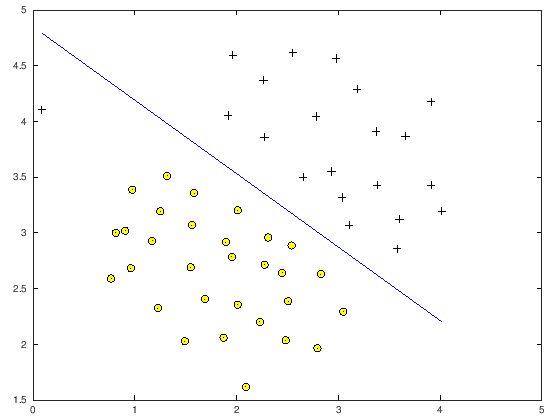

In [199]:
% You should try to change the C value below and see how the decision
% boundary varies (e.g., try C = 1000)
C = 1;
model = svmTrain(X, y, C, @linearKernel, 1e-3, 20);
visualizeBoundaryLinear(X, y, model);
%model

In [36]:
%% =============== Part 3: Implementing Gaussian Kernel ===============
%  You will now implement the Gaussian kernel to use
%  with the SVM. You should complete the code in gaussianKernel.m

In [19]:
fprintf('\nEvaluating the Gaussian Kernel ...\n')


Evaluating the Gaussian Kernel ...


In [11]:
function sim = gaussianKernel(x1, x2, sigma)
%RBFKERNEL returns a radial basis function kernel between x1 and x2
%   sim = gaussianKernel(x1, x2) returns a gaussian kernel between x1 and x2
%   and returns the value in sim
% Ensure that x1 and x2 are column vectors
x1 = x1(:); x2 = x2(:);
% You need to return the following variables correctly.
sim = 0;
% ====================== YOUR CODE HERE ======================
% Instructions: Fill in this function to return the similarity between x1
%               and x2 computed using a Gaussian kernel with bandwidth
%               sigma
%
%
sim=exp(-sum((x1-x2) .^ 2)/2/sigma/sigma);
% =============================================================  
end

In [12]:
x1 = [1 2 1]; x2 = [0 4 -1]; sigma = 2;
sim = gaussianKernel(x1, x2, sigma);

In [13]:
fprintf(['Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = %f :' ...
         '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n'], sigma, sim);

Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = 2.000000 :
	0.324652
(for sigma = 2, this value should be about 0.324652)


In [27]:
%% =============== Part 4: Visualizing Dataset 2 ================
%  The following code will load the next dataset into your environment and 
%  plot the data. 

In [28]:
fprintf('Loading and Visualizing Data ...\n')

Loading and Visualizing Data ...


In [184]:
% Load from ex6data2: 
% You will have X, y in your environment
load('ex6data2.mat');

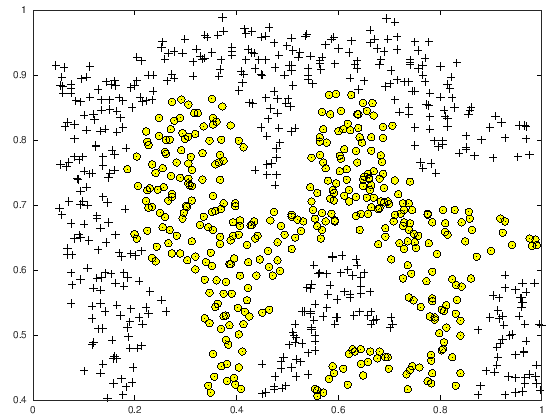

In [185]:
% Plot training data
plotData(X, y);

In [31]:
%% ========== Part 5: Training SVM with RBF Kernel (Dataset 2) ==========
%  After you have implemented the kernel, we can now use it to train the 
%  SVM classifier.

In [32]:
fprintf('\nTraining SVM with RBF Kernel (this may take 1 to 2 minutes) ...\n');


Training SVM with RBF Kernel (this may take 1 to 2 minutes) ...


In [40]:
% Load from ex6data2: 
% You will have X, y in your environment
load('ex6data2.mat');

In [41]:
% SVM Parameters
C = 1; sigma = 0.1;

In [74]:
function visualizeBoundary(X, y, model, varargin)
%VISUALIZEBOUNDARY plots a non-linear decision boundary learned by the SVM
%   VISUALIZEBOUNDARYLINEAR(X, y, model) plots a non-linear decision 
%   boundary learned by the SVM and overlays the data on it
% Plot the training data on top of the boundary
plotData(X, y)
% Make classification predictions over a grid of values
x1plot = linspace(min(X(:,1)), max(X(:,1)), 100)';
x2plot = linspace(min(X(:,2)), max(X(:,2)), 100)';
[X1, X2] = meshgrid(x1plot, x2plot);
vals = zeros(size(X1));
for i = 1:size(X1, 2)
   this_X = [X1(:, i), X2(:, i)];
   vals(:, i) = svmPredict(model, this_X);
end
% Plot the SVM boundary
hold on
contour(X1, X2, vals, [0.5 0.5], 'b');
hold off;
end

In [56]:
function pred = svmPredict(model, X)
%SVMPREDICT returns a vector of predictions using a trained SVM model
%(svmTrain). 
%   pred = SVMPREDICT(model, X) returns a vector of predictions using a 
%   trained SVM model (svmTrain). X is a mxn matrix where there each 
%   example is a row. model is a svm model returned from svmTrain.
%   predictions pred is a m x 1 column of predictions of {0, 1} values.
%

% Check if we are getting a column vector, if so, then assume that we only
% need to do prediction for a single example
if (size(X, 2) == 1)
    % Examples should be in rows
    X = X';
end

% Dataset 
m = size(X, 1);
p = zeros(m, 1);
pred = zeros(m, 1);

if strcmp(func2str(model.kernelFunction), 'linearKernel')
    % We can use the weights and bias directly if working with the 
    % linear kernel
    p = X * model.w + model.b;
elseif strfind(func2str(model.kernelFunction), 'gaussianKernel')
    % Vectorized RBF Kernel
    % This is equivalent to computing the kernel on every pair of examples
    X1 = sum(X.^2, 2);
    X2 = sum(model.X.^2, 2)';
    K = bsxfun(@plus, X1, bsxfun(@plus, X2, - 2 * X * model.X'));
    K = model.kernelFunction(1, 0) .^ K;
    K = bsxfun(@times, model.y', K);
    K = bsxfun(@times, model.alphas', K);
    p = sum(K, 2);
else
    % Other Non-linear kernel
    for i = 1:m
        prediction = 0;
        for j = 1:size(model.X, 1)
            prediction = prediction + ...
                model.alphas(j) * model.y(j) * ...
                model.kernelFunction(X(i,:)', model.X(j,:)');
        end
        p(i) = prediction + model.b;
    end
end
% Convert predictions into 0 / 1
pred(p >= 0) =  1;
pred(p <  0) =  0;
end


Training ......................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...................................... Done! 



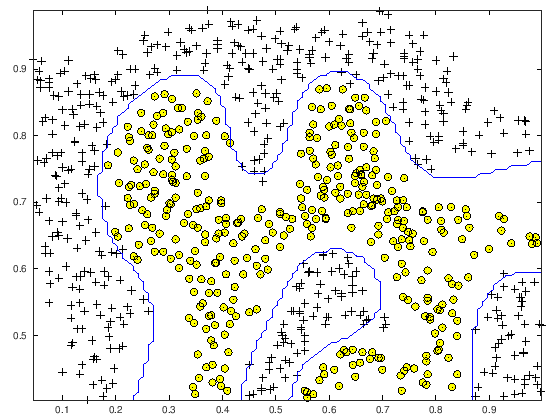

In [57]:
% We set the tolerance and max_passes lower here so that the code will run
% faster. However, in practice, you will want to run the training to
% convergence.
model= svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma)); 
visualizeBoundary(X, y, model);

In [38]:
%% =============== Part 6: Visualizing Dataset 3 ================
%  The following code will load the next dataset into your environment and 
%  plot the data. 

In [39]:
fprintf('Loading and Visualizing Data ...\n')

Loading and Visualizing Data ...


In [40]:
% Load from ex6data3: 
% You will have X, y in your environment
load('ex6data3.mat');

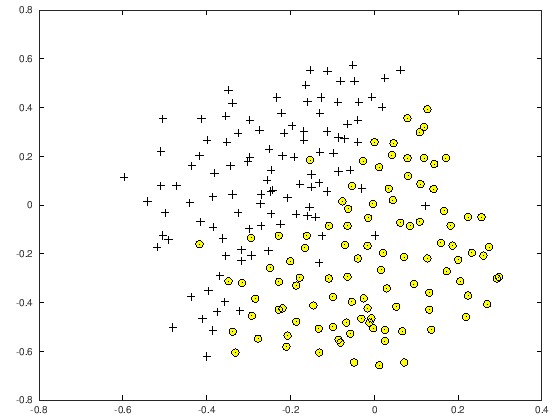

In [41]:
% Plot training data
plotData(X, y);

In [42]:
%% ========== Part 7: Training SVM with RBF Kernel (Dataset 3) ==========

%  This is a different dataset that you can use to experiment with. Try
%  different values of C and sigma here.

In [76]:
% Load from ex6data3: 
% You will have X, y in your environment
load('ex6data3.mat');

In [77]:
whos

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        C           1x1                          8  double
        X         211x2                       3376  double
        Xval      200x2                       3200  double
        a         863x1                       6904  double
        ans         1x1                          8  double
        model       1x1                       7256  struct
        sigma       1x1                          8  double
        sim         1x1                          8  double
        x1          1x3                         24  double
        x2          1x3                         24  double
        y         211x1                       1688  double
        yval      200x1                       1600  double

Total is 2107 elements using 24104 bytes



In [78]:
function [C, sigma] = dataset3Params(X, y, Xval, yval)
%DATASET3PARAMS returns your choice of C and sigma for Part 3 of the exercise
%where you select the optimal (C, sigma) learning parameters to use for SVM
%with RBF kernel
%   [C, sigma] = DATASET3PARAMS(X, y, Xval, yval) returns your choice of C and 
%   sigma. You should complete this function to return the optimal C and 
%   sigma based on a cross-validation set.
%
% You need to return the following variables correctly.
C = 1;
sigma = 0.3;
% ====================== YOUR CODE HERE ======================
% Instructions: Fill in this function to return the optimal C and sigma
%               learning parameters found using the cross validation set.
%               You can use svmPredict to predict the labels on the cross
%               validation set. For example, 
%                   predictions = svmPredict(model, Xval);
%               will return the predictions on the cross validation set.
%
%  Note: You can compute the prediction error using 
%        mean(double(predictions ~= yval))
%
wid=[0.01;0.03;0.1;0.3;1;3;10;30];
errors=0;
for i=1:size(wid,1)
    for j=1:size(wid,1)
        model= svmTrain(X, y, wid(i), @(x1, x2) gaussianKernel(x1, x2, wid(j)));
        predictions=svmPredict(model, Xval);
        errors(i,j)=mean(double(predictions ~= yval));
    end
end
error=min(min(errors));
[i,j]=find(errors==error);
C=wid(i);
sigma=wid(j);
% =========================================================================
end

In [79]:
% Try different SVM Parameters here
[C, sigma] = dataset3Params(X, y, Xval, yval);


Training ........................... Done! 


Training .............................................................. Done! 


Training .............................................................. Done! 


Training ................................. Done! 


Training ................................................ Done! 


Training ..................................... Done! 


Training ................................... Done! 


Training ........................... Done! 


Training ................................ Done! 


Training ................................................... Done! 


Training ................................................ Done! 


Training ........................................................ Done! 


Training .............................. Done! 


Training .......................................... Done! 


Training ................................................ Done! 


Training .......................................... Done! 


Training ......

............. Done! 


Training ......................................................................
................................ Done! 


Training ......................................................................
... Done! 


Training ................................ Done! 



In [80]:
C, sigma

C =  1
sigma =  0.10000


In [47]:
whos

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        C           1x1                          8  double
        X         211x2                       3376  double
        Xval      200x2                       3200  double
        model       1x1                       7096  struct
        sigma       1x1                          8  double
        sim         1x1                          8  double
        x1          1x3                         24  double
        x2          1x3                         24  double
        y         211x1                       1688  double
        yval      200x1                       1600  double

Total is 1243 elements using 17032 bytes




Training ......................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
............... Done! 



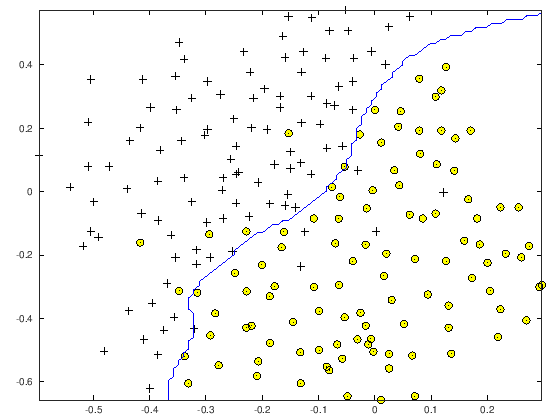

In [48]:
% Train the SVM
model= svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma));
visualizeBoundary(X, y, model);